window = 100
epoch = 20
batch = 100
dropout = .02

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
!pwd

/Users/josephbarry/Desktop/FinTech_Class/3rd_Project/FinTech_Portfolio_Dash/JGB_Notebook


In [3]:
csvpath = Path("NVDA.csv")

df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-08-16,3.3050,3.3500,3.1875,3.2475,2.984078,71686800
2011-08-17,3.2575,3.3125,3.1600,3.2025,2.942729,55332800
2011-08-18,3.0575,3.0875,2.9500,2.9850,2.742872,80256400
2011-08-19,2.9350,3.0975,2.9125,2.9325,2.694630,76133200
2011-08-22,3.0150,3.0500,2.9525,2.9850,2.742872,61187600


In [4]:
df = df[['Close']]
df

,Close
Date,
2011-08-16,3.247500
2011-08-17,3.202500
2011-08-18,2.985000
2011-08-19,2.932500
2011-08-22,2.985000
...,...
2021-08-09,202.949997
2021-08-10,199.360001
2021-08-11,196.990005


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[3.2475 3.2025 2.985  2.9325 2.985  3.3075 3.26   3.12   3.2525 3.34
  3.42   3.3275 3.32   3.23   3.295  3.5625 3.545  3.47   3.5525 3.6325
  3.82   3.875  3.865  3.785  3.6875 3.6175 3.3775 3.4475 3.455  3.46
  3.355  3.2725 3.1275 2.9525 3.225  3.34   3.4725 3.5375 3.695  3.655
  3.6525 3.865  3.93   3.735  3.87   3.7925 3.6025 3.62   3.755  3.6125
  3.655  3.8125 3.9    3.7    3.515  3.455  3.6625 3.705  3.685  3.77
  3.58   3.6175 3.745  3.6725 3.72   3.645  3.515  3.4825 3.6575 3.77
  3.61   3.51   3.7075 3.7275 3.9075 3.955  3.93   3.87   3.815  3.7925
  3.6725 3.725  3.6325 3.5325 3.395  3.365  3.3775 3.29   3.475  3.43
  3.5775 3.5425 3.515  3.4275 3.4925 3.465  3.51   3.55   3.6775 3.635 ]
 [3.2025 2.985  2.9325 2.985  3.3075 3.26   3.12   3.2525 3.34   3.42
  3.3275 3.32   3.23   3.295  3.5625 3.545  3.47   3.5525 3.6325 3.82
  3.875  3.865  3.785  3.6875 3.6175 3.3775 3.4475 3.455  3.46   3.355
  3.2725 3.1275 2.9525 3.225  3.34   3.4725 3.5375 3.695  3.65

In [7]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
#x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
#y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
#x_test_scaler.fit(X_test)
#y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [9]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [12]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [13]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 66ms/step - loss: 0.0010
Epoch 2/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0173
Epoch 3/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0079
Epoch 4/20
15/15 [==============================] - 1s 64ms/step - loss: 0.0133
Epoch 5/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0204
Epoch 6/20
15/15 [==============================] - 1s 64ms/step - loss: 0.0109
Epoch 7/20
15/15 [==============================] - 1s 64ms/step - loss: 0.0448
Epoch 8/20
15/15 [==============================] - 1s 64ms/step - loss: 0.0243
Epoch 9/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0262
Epoch 10/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0101
Epoch 11/20
15/15 [==============================] - 1s 65ms/step - loss: 0.0136
Epoch 12/20
15/15 [==============================] - 1s 66ms/step - loss: 0.0031
Epoch 13/20
15/15 [==================

In [14]:
model.evaluate(X_test, y_test, verbose=0)

1.188315987586975

In [15]:
predicted = model.predict(X_test)

In [16]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [17]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [18]:
actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_predicted.head()

,Actual,Predicted
Date,,
2017-10-12,47.735001,32.126762
2017-10-13,47.757500,32.236282
2017-10-16,48.647499,32.373203
2017-10-17,49.482498,32.537788
2017-10-18,49.437500,32.731289


In [19]:
actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,203.660004,69.285728
2021-08-10,202.949997,69.363319
2021-08-11,199.360001,69.440613
2021-08-12,196.990005,69.504913
2021-08-13,199.050003,69.548546


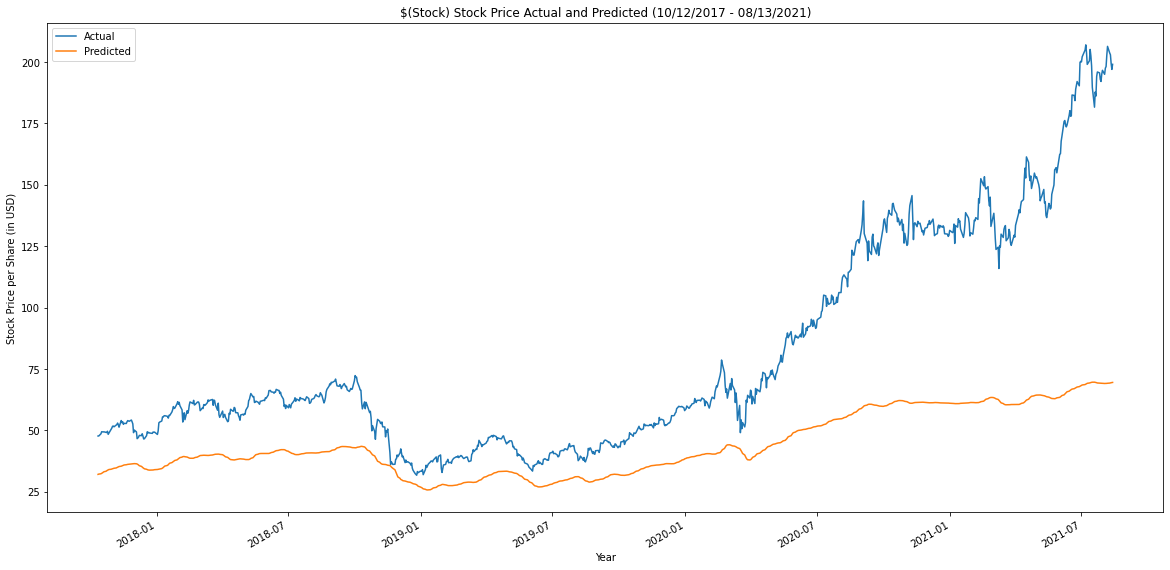

In [20]:
actual_predicted.plot(figsize=(20,10))
plt.title('$(Stock) Stock Price Actual and Predicted (10/12/2017 - 08/13/2021)')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc="best")
plt.show()